<a href="https://colab.research.google.com/github/wayne1123/Topic/blob/master/WGAN_MNIST_Pytorch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5c9da000 @  0x7fa2667872a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.0
True


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data
import torchvision
from torch import autograd
from torchvision import datasets, transforms
from torchvision.models.inception import inception_v3
from torch.autograd import Variable

from skimage.color import lab2rgb, rgb2lab, rgb2gray
from sklearn.decomposition import PCA
from scipy.stats import entropy

In [4]:
BATCH = 16
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH,
                                         shuffle=False, num_workers=2)

Processing...
Done!


In [0]:
def one_hot(test,i=10):
  b = torch.zeros(test.shape[0],i)
  b[np.arange(test.shape[0]),test] = 1
  return b

#### It is WGAN-GP but the Discriminator(Critic) classifies the hand-digit examples into 0 ~9

#### Generator Structure

* Dense(128->256) + LeakyReLU + BN -> Reshape(-1, 16, 4, 4) 
* Convolution Block(16->64, filter=3) + LeakyReLU + BN 
* [Transposed Convolution(ch:64, filter=3, stride=2,)  + LeakyReLU + BN] X 3
* Convolution(64->1, filter=3) + Tanh, multiply 0.5 and add 0.5 - it generates better gradients than sigmoid..

#### Discriminator Structure

* [Convolution(filter=5, stride=2, ch_out = 4*ch_in) + LeakyReLU] X 2
* [Convolution(filter=3, stride=2, ch_out = 2*ch_in)+ LeakyReLU] X 2
* Output 1 : Convolution(filter=3, stride=1, ch_out=1, ch_in=64) -> Working as a Critic
* Output 2 : Linear (256 -> 10), Then Cross-entropy loss -> Working as a classifier

#### Characteristics

* It is conditional WGAN-GP : To control the output using the label variables
* Use the term **Discriminator** instead of **Critic**.. no specific reasons
* No Batch Normalization on Discriminator : Batch Normalization is known to have the dependency across the mini-batches. This affects the performance of the Discriminator badly.. so no Batch Normalization
* Simple is good - not necessary to use skipping.. adding residuals
* Learning rate: 1e-4
* Loss: **Wasserstein-1 Distance** for Critics, and **Softmax** for classification

#### Results

* It seems like that the Critics could label the generated images - but the quality of the generated images is not that good.
* Critics could discern whether the image is real and at the same time it could classify the images into labels. Two processes could be done simulataneously. 
* Maybe used to generate images & label them at the same time





In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.Conv2d(16,64,3,1,1)
    self.conv2 = nn.ConvTranspose2d(64,64,3,2,1,1)
    self.conv3 = nn.ConvTranspose2d(64,64,3,2,1,1)
    self.conv4 = nn.ConvTranspose2d(64,64,3,2,1,1)
    self.conv5 = nn.Conv2d(64,1,3,1,1)
    self.bn0 = nn.BatchNorm1d(256)
    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)
    self.sigmoid = nn.Sigmoid()
    self.leakyrelu = nn.LeakyReLU(0.2)
    self.dense = nn.Linear(128,256)
    self.tanh = nn.Tanh()
    
  def forward(self):
    z = torch.randn(BATCH,128).cuda()
    #z = torch.cat([z,label],1)
    z = self.bn0(self.leakyrelu(self.dense(z)))
    z = z.reshape(-1,16,4,4)
    x = self.bn1(self.leakyrelu(self.conv1(z)))
    x = self.bn2(self.leakyrelu(self.conv2(x)))
    x = self.bn3(self.leakyrelu(self.conv3(x)))
    x = self.bn4(self.leakyrelu(self.conv4(x)))
    x = self.tanh(self.conv5(x)) * .5 + .5
    out = x[:,:,2:-2,2:-2]
    return out

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.leakyrelu = nn.LeakyReLU(0.2)
    self.conv1 = nn.Conv2d(1,4,5,2,2)
    self.avg1 = nn.AvgPool2d(7)
    self.conv2 = nn.Conv2d(4,16,5,2,2)
    self.avg2 = nn.AvgPool2d(2)
    self.conv3 = nn.Conv2d(16,64,3,2,1)
    self.conv4 = nn.Conv2d(64,256,3,2,1)
    self.conv5 = nn.Conv2d(256,256,2,2)
    self.avg = nn.AvgPool2d(2)
    self.linear1 = nn.Linear(256,1)
    self.linear2 = nn.Linear(256,10)
  def forward(self, x):
    z = self.leakyrelu(self.conv1(x))
    z = self.leakyrelu(self.conv2(z))
    z = self.leakyrelu(self.conv3(z))
    z = self.leakyrelu(self.conv4(z))
    z = self.leakyrelu(self.conv5(z))
    z = z.reshape(-1,256)
    out1 = self.linear1(z)
    out2 = self.linear2(z)
    return out1, out2
    
    
    

In [0]:
def gradient_penalty(C, real_data, fake_data, lamb=10):
    assert real_data.size() == fake_data.size()
    a = torch.rand(real_data.size(0),1).cuda()
    a = a\
    .expand(real_data.size(0), real_data.nelement()//real_data.size(0))\
    .contiguous()\
    .view(
    real_data.size(0),
    1,28,28
    )
    interpolated = Variable(a*real_data + (1-a)*fake_data, 
                            requires_grad=True)
    c, _ = C(interpolated)
    gradients = autograd.grad(
    c, interpolated, grad_outputs=(
    torch.ones(c.size()).cuda())
    ,create_graph=True, retain_graph=True)[0]
    return lamb*((1-(gradients).norm(2,dim=1))**2).mean()

In [0]:
def train(G,D, l=1e-4, n_epochs=15, start=0, weight_decay = True):
  i = 0
  j = -1
  loss_list = []
  for epoch in range(start,n_epochs):
    if weight_decay:
      lr_ = l * (n_epochs - epoch+1) / n_epochs
    else:
      lr_ = l
    #lr_ = 1e-5
    G_op = optim.Adam(G.parameters(), lr = lr_, betas=(0.5,0.999))
    D_op = optim.Adam(D.parameters(), lr = lr_, betas=(0.5,0.999))
    for _, data in enumerate(trainloader):
      image, label = data
      y = one_hot(label)
      image, label = image.cuda(), label.cuda()
      D_op.zero_grad()
      sample = G()
      d_sample, _ = D(sample.detach())
      d_input, d_input2 = D(image)
      w_d = torch.mean(d_input) - torch.mean(d_sample)
      gp = gradient_penalty(D,image,sample,10)
      d_loss = -w_d + gp
      
      bce = ce(d_input2,label)
      d_loss += bce
      d_loss.backward()
      D_op.step()
      
      
      
      if i % 5 == 1:
        G_op.zero_grad()
        sample_ = G()
        d_sample, _ = D(sample_)
        g_loss = -torch.mean(d_sample)
        g_loss.backward()
        G_op.step()
        loss_list.append([w_d.data[0],d_loss.data[0],bce.data[0],g_loss.data[0]])
        
      if i%100 == 1:
        print("epoch={}, iteration={}, WD={}, D_loss={}, bce={}, G_loss={}".format(epoch,i,w_d.data[0],d_loss.data[0], bce.data[0],g_loss.data[0]))
      i += 1
      if epoch > j:
        print("learning rate : {} ".format(lr_))
        display = G()
        display = display.detach()
        _, labels = D(display)
        predicted_label = torch.max(labels.data, 1)
        display = display[:16]
        fig = plt.figure(figsize=(6,6))
        gs = gridspec.GridSpec(4,4)
        gs.update(wspace=0.05, hspace=0.05)
        for j, sample in enumerate(display):
          ax = plt.subplot(gs[j])
          plt.axis('off')
          ax.set_xticklabels([])
          ax.set_yticklabels([])
          ax.set_aspect('equal')
          plt.imshow(sample.reshape(28,28),cmap = plt.cm.gray)
        plt.show()
        print("Labels : ", predicted_label)
        with torch.no_grad():
          label_list = []
          total = 0
          correct = 0
          for data in testloader:
            image, labels = data
            image, labels = image.cuda(), labels.cuda()
            _, output = D(image)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
          print("Classification Accuracy : %d %% " % (100*correct/total))
            
        j = epoch
  return loss_list
        

In [0]:
ce = nn.CrossEntropyLoss(size_average=False)

learning rate : 0.0001 


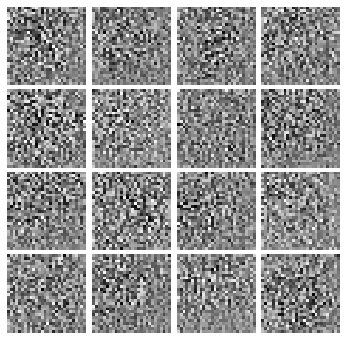

Labels :  (tensor(1.00000e-02 *
       [ 7.0497,  6.8855,  6.7588,  6.9007,  7.0030,  6.7269,  6.9184,
         6.7847,  6.8957,  7.0068,  6.9042,  6.8439,  6.8335,  6.9642,
         6.9788,  6.8711], device='cuda:0'), tensor([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6], device='cuda:0'))
Classification Accuracy : 9 % 
epoch=0, iteration=1, WD=-0.00028502941131591797, D_loss=46.80938720703125, bce=36.81144332885742, G_loss=-0.03288865089416504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch=0, iteration=101, WD=8.05594253540039, D_loss=33.185733795166016, bce=31.916152954101562, G_loss=13.064108848571777
epoch=0, iteration=201, WD=840.2301025390625, D_loss=-582.7157592773438, bce=52.82704544067383, G_loss=1465.910888671875
epoch=0, iteration=301, WD=1414.03173828125, D_loss=-838.4581909179688, bce=46.25458526611328, G_loss=1606.5609130859375
epoch=0, iteration=401, WD=1105.111083984375, D_loss=-626.5231323242188, bce=37.60486602783203, G_loss=1320.2510986328125
epoch=0, iteration=501, WD=1104.4505615234375, D_loss=-660.1309204101562, bce=16.712068557739258, G_loss=1181.732421875
epoch=0, iteration=601, WD=1091.9366455078125, D_loss=-611.18505859375, bce=21.843992233276367, G_loss=1168.132568359375
epoch=0, iteration=701, WD=1200.011474609375, D_loss=-646.5254516601562, bce=23.788719177246094, G_loss=1240.2176513671875
epoch=0, iteration=801, WD=857.9464111328125, D_loss=-420.40667724609375, bce=17.401552200317383, G_loss=1001.3193359375
epoch=0, iteration=901, WD=37

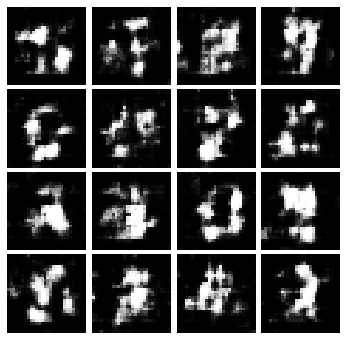

Labels :  (tensor([ 4.6048,  1.6846,  5.3644,  7.3013,  9.8675,  4.3292,  6.3919,
         9.6823,  6.3258,  7.0154,  4.5046,  7.7753,  5.7508,  5.2934,
         3.5118,  7.3222], device='cuda:0'), tensor([ 5,  3,  3,  7,  6,  7,  8,  0,  2,  6,  0,  3,  8,  3,
         8,  3], device='cuda:0'))
Classification Accuracy : 81 % 
epoch=1, iteration=3801, WD=20.343841552734375, D_loss=-8.334285736083984, bce=6.839077472686768, G_loss=-101.31719207763672
epoch=1, iteration=3901, WD=25.9493408203125, D_loss=-6.501019477844238, bce=13.731009483337402, G_loss=-68.69535064697266
epoch=1, iteration=4001, WD=23.233257293701172, D_loss=-7.0475263595581055, bce=9.988595008850098, G_loss=-28.601465225219727
epoch=1, iteration=4101, WD=15.834251403808594, D_loss=2.3206443786621094, bce=9.852205276489258, G_loss=-21.843881607055664
epoch=1, iteration=4201, WD=38.181602478027344, D_loss=-18.03545570373535, bce=13.294889450073242, G_loss=-61.76620864868164
epoch=1, iteration=4301, WD=24.533538818359375,

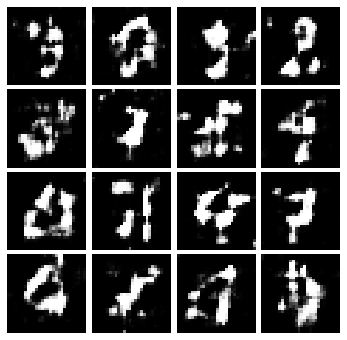

Labels :  (tensor([  9.0491,   9.7325,   5.0032,  10.1242,   6.3669,   4.9077,
          7.2041,   5.7263,  12.1400,  12.6989,  10.5985,   6.7450,
          5.8245,   4.9031,   8.4797,   8.4350], device='cuda:0'), tensor([ 7,  0,  5,  3,  2,  1,  5,  4,  0,  2,  9,  7,  9,  8,
         3,  3], device='cuda:0'))
Classification Accuracy : 87 % 
epoch=2, iteration=7501, WD=29.203224182128906, D_loss=-14.653624534606934, bce=4.210736274719238, G_loss=-63.04574203491211
epoch=2, iteration=7601, WD=19.581886291503906, D_loss=-3.412141799926758, bce=6.282186508178711, G_loss=-74.45030212402344
epoch=2, iteration=7701, WD=27.62744903564453, D_loss=-13.284994125366211, bce=3.5307440757751465, G_loss=-81.89859008789062
epoch=2, iteration=7801, WD=36.967803955078125, D_loss=-21.18365478515625, bce=6.111847877502441, G_loss=-59.61900329589844
epoch=2, iteration=7901, WD=24.68316650390625, D_loss=-11.483880996704102, bce=2.372478723526001, G_loss=-76.94168853759766
epoch=2, iteration=8001, WD=34.02

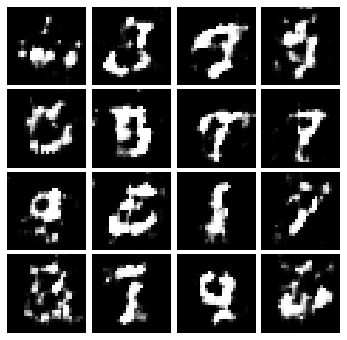

Labels :  (tensor([ 11.9308,  16.3829,   8.7205,   4.9755,   9.4458,   4.3591,
          6.9765,   7.6237,   9.3551,  13.1532,   3.9186,   3.5850,
          9.4230,   7.3734,   6.3878,  18.3803], device='cuda:0'), tensor([ 2,  3,  5,  9,  0,  3,  9,  7,  9,  0,  1,  8,  3,  3,
         9,  6], device='cuda:0'))
Classification Accuracy : 89 % 
epoch=3, iteration=11301, WD=40.48278045654297, D_loss=-21.951377868652344, bce=3.1374096870422363, G_loss=-80.5805892944336
epoch=3, iteration=11401, WD=41.338783264160156, D_loss=-22.581188201904297, bce=6.101208686828613, G_loss=-107.79574584960938
epoch=3, iteration=11501, WD=37.995670318603516, D_loss=-15.202495574951172, bce=6.398809909820557, G_loss=-40.90489959716797
epoch=3, iteration=11601, WD=54.292789459228516, D_loss=-33.69343948364258, bce=4.2514328956604, G_loss=66.67382049560547
epoch=3, iteration=11701, WD=38.36772155761719, D_loss=-20.97469139099121, bce=1.1010456085205078, G_loss=-21.36040496826172
epoch=3, iteration=11801, WD=6

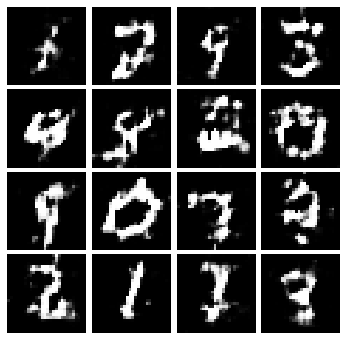

Labels :  (tensor([  3.3282,  10.6433,   5.6648,   9.6238,  13.0533,   4.9103,
         11.5276,   6.1947,   6.2953,  16.3208,  12.1598,   6.0631,
          9.9129,   5.8902,   4.8734,   4.7750], device='cuda:0'), tensor([ 1,  7,  4,  3,  4,  8,  2,  0,  9,  0,  7,  9,  2,  1,
         3,  3], device='cuda:0'))
Classification Accuracy : 93 % 
epoch=4, iteration=15001, WD=99.5513687133789, D_loss=-82.6245346069336, bce=0.5907077789306641, G_loss=-96.94820404052734
epoch=4, iteration=15101, WD=44.50828552246094, D_loss=-27.40531349182129, bce=1.5067315101623535, G_loss=-43.38650894165039
epoch=4, iteration=15201, WD=38.616119384765625, D_loss=-18.638561248779297, bce=0.9067144393920898, G_loss=-13.335617065429688
epoch=4, iteration=15301, WD=30.558879852294922, D_loss=-11.375920295715332, bce=3.387005090713501, G_loss=5.661708354949951
epoch=4, iteration=15401, WD=37.05712127685547, D_loss=-21.00519561767578, bce=0.7925333976745605, G_loss=-89.58722686767578
epoch=4, iteration=15501, WD=

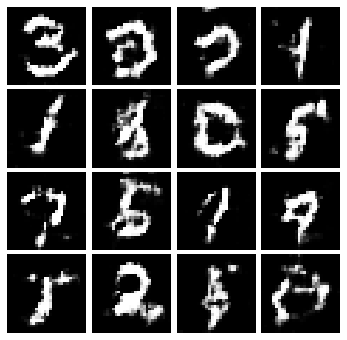

Labels :  (tensor([ 13.0625,   8.2816,   8.4966,   5.4357,   7.7616,   7.0485,
         13.8359,   6.6863,  13.8345,   7.2472,   3.8930,   6.8989,
          5.5500,  19.3744,   4.8399,   5.1860], device='cuda:0'), tensor([ 3,  0,  7,  1,  1,  8,  0,  8,  7,  5,  7,  7,  1,  2,
         8,  0], device='cuda:0'))
Classification Accuracy : 94 % 
epoch=5, iteration=18801, WD=48.539466857910156, D_loss=-32.08377456665039, bce=2.6263017654418945, G_loss=-63.66244888305664
epoch=5, iteration=18901, WD=37.92399978637695, D_loss=-21.521282196044922, bce=1.4511539936065674, G_loss=-31.337833404541016
epoch=5, iteration=19001, WD=38.67642593383789, D_loss=-21.019906997680664, bce=0.432924747467041, G_loss=-21.486377716064453
epoch=5, iteration=19101, WD=38.58367919921875, D_loss=-19.68195343017578, bce=2.1599955558776855, G_loss=36.50049591064453
epoch=5, iteration=19201, WD=43.16049575805664, D_loss=-22.507530212402344, bce=8.114476203918457, G_loss=-28.336742401123047
epoch=5, iteration=19301, 

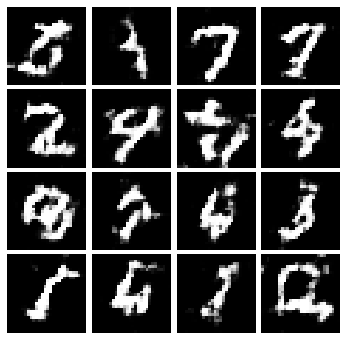

Labels :  (tensor([  7.6510,   3.9748,  14.2526,   8.9121,  17.9602,   6.7613,
          6.6919,   4.0655,   6.3145,   4.3114,   8.6942,   4.7064,
          5.0350,   8.7781,   4.6151,  13.4659], device='cuda:0'), tensor([ 3,  3,  7,  7,  2,  4,  8,  4,  8,  7,  6,  3,  1,  6,
         2,  2], device='cuda:0'))
Classification Accuracy : 95 % 
epoch=6, iteration=22501, WD=43.29515075683594, D_loss=-23.92316246032715, bce=4.821752548217773, G_loss=17.08826446533203
epoch=6, iteration=22601, WD=30.596145629882812, D_loss=-12.687080383300781, bce=1.483048915863037, G_loss=-101.4749984741211
epoch=6, iteration=22701, WD=43.74065399169922, D_loss=-28.848297119140625, bce=2.17008113861084, G_loss=-51.123809814453125
epoch=6, iteration=22801, WD=39.035911560058594, D_loss=-23.857450485229492, bce=1.702110767364502, G_loss=46.791500091552734
epoch=6, iteration=22901, WD=53.09373474121094, D_loss=-37.28562927246094, bce=0.832017183303833, G_loss=-117.1239013671875
epoch=6, iteration=23001, WD=37

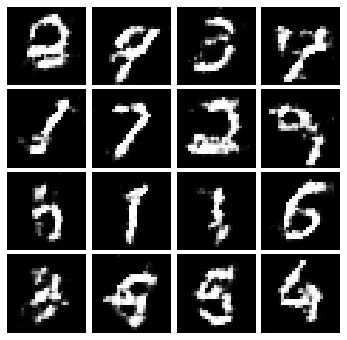

Labels :  (tensor([  6.7391,   9.0381,   9.2364,   7.2338,   7.2220,   8.5122,
         16.9475,   5.2708,   2.3643,   5.7322,   7.1379,  10.8139,
          2.7794,   5.4866,   7.6968,   5.9121], device='cuda:0'), tensor([ 2,  9,  3,  7,  1,  7,  2,  3,  8,  1,  1,  5,  3,  5,
         5,  4], device='cuda:0'))
Classification Accuracy : 95 % 
epoch=7, iteration=26301, WD=29.45140838623047, D_loss=-15.548247337341309, bce=1.0033788681030273, G_loss=-58.02189254760742
epoch=7, iteration=26401, WD=55.181549072265625, D_loss=-41.59073257446289, bce=0.5712771415710449, G_loss=-59.95864486694336
epoch=7, iteration=26501, WD=30.292091369628906, D_loss=-17.739599227905273, bce=0.49725770950317383, G_loss=-72.2236328125
epoch=7, iteration=26601, WD=42.695899963378906, D_loss=-25.598491668701172, bce=0.5833609104156494, G_loss=42.229164123535156
epoch=7, iteration=26701, WD=28.075288772583008, D_loss=-13.765459060668945, bce=1.7845056056976318, G_loss=-21.042295455932617
epoch=7, iteration=26801

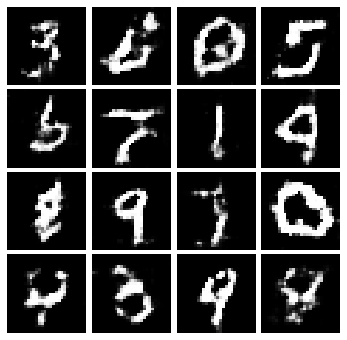

Labels :  (tensor([  8.4550,   7.8279,   7.1230,  15.9144,   4.4889,  15.6067,
          8.1101,   6.0270,   4.8638,   7.9280,   4.7446,   9.4775,
         10.0751,   7.9734,   7.3258,   7.7772], device='cuda:0'), tensor([ 3,  6,  0,  5,  6,  7,  1,  9,  8,  9,  3,  0,  4,  3,
         4,  4], device='cuda:0'))
Classification Accuracy : 96 % 
epoch=8, iteration=30001, WD=19.742095947265625, D_loss=-5.968970775604248, bce=0.6353039741516113, G_loss=-72.61380004882812
epoch=8, iteration=30101, WD=16.709924697875977, D_loss=-1.1918597221374512, bce=2.2784476280212402, G_loss=16.078256607055664
epoch=8, iteration=30201, WD=30.80959701538086, D_loss=-16.845762252807617, bce=0.8332505226135254, G_loss=1.4449787139892578
epoch=8, iteration=30301, WD=35.916053771972656, D_loss=-22.755327224731445, bce=0.8815023899078369, G_loss=10.772743225097656
epoch=8, iteration=30401, WD=45.23949432373047, D_loss=-28.355411529541016, bce=1.870044231414795, G_loss=-74.320068359375
epoch=8, iteration=30501, 

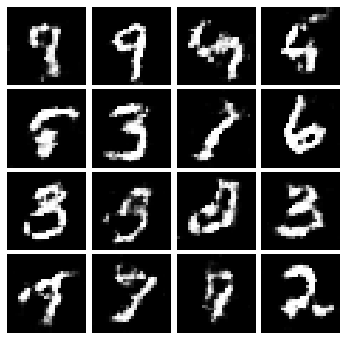

Labels :  (tensor([  4.7819,   9.3826,   2.4991,   4.4757,  12.0164,  16.4273,
          4.7113,  11.9640,   8.4548,   5.3403,   5.9794,  11.1308,
          7.9802,   7.5978,   3.1942,  18.2545], device='cuda:0'), tensor([ 7,  9,  4,  4,  5,  3,  1,  6,  3,  5,  2,  3,  7,  7,
         7,  2], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=9, iteration=33801, WD=19.824161529541016, D_loss=-10.135767936706543, bce=0.3116722106933594, G_loss=4.1315155029296875
epoch=9, iteration=33901, WD=28.578575134277344, D_loss=-12.470263481140137, bce=2.9098289012908936, G_loss=-93.92442321777344
epoch=9, iteration=34001, WD=29.837844848632812, D_loss=-12.983040809631348, bce=1.8018512725830078, G_loss=-121.02589416503906
epoch=9, iteration=34101, WD=27.58951759338379, D_loss=-16.913522720336914, bce=0.11943578720092773, G_loss=-10.540470123291016
epoch=9, iteration=34201, WD=39.29695129394531, D_loss=-26.200698852539062, bce=1.4061691761016846, G_loss=-88.71492767333984
epoch=9, iteration=

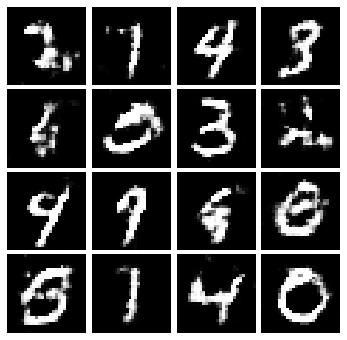

Labels :  (tensor([  9.4891,   4.9170,  13.4894,   9.2050,   2.6189,   5.2410,
         14.5473,   9.6622,   9.9397,   5.5308,   3.3271,   4.8600,
          5.3126,   5.6643,  12.6976,  10.1068], device='cuda:0'), tensor([ 2,  1,  4,  3,  4,  5,  3,  2,  4,  9,  6,  6,  5,  1,
         4,  0], device='cuda:0'))
Classification Accuracy : 96 % 
epoch=10, iteration=37501, WD=14.035301208496094, D_loss=-2.2356514930725098, bce=2.0671610832214355, G_loss=-119.52369689941406
epoch=10, iteration=37601, WD=13.959878921508789, D_loss=-3.6002118587493896, bce=0.38943982124328613, G_loss=-1.1535942554473877
epoch=10, iteration=37701, WD=32.020999908447266, D_loss=-18.666105270385742, bce=2.594910144805908, G_loss=-1.5033864974975586
epoch=10, iteration=37801, WD=35.14624786376953, D_loss=-25.116640090942383, bce=0.45559263229370117, G_loss=-107.66464233398438
epoch=10, iteration=37901, WD=18.078643798828125, D_loss=-5.635240077972412, bce=1.8065638542175293, G_loss=-116.759765625
epoch=10, iterat

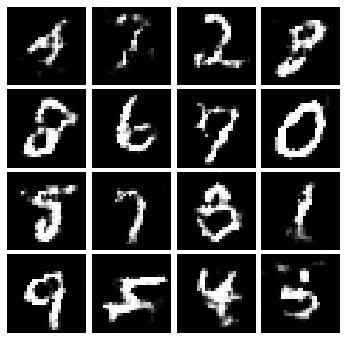

Labels :  (tensor([  4.5440,   2.7916,  13.5570,   3.8745,   6.9004,  11.4253,
          4.8074,  12.6968,   4.4265,   6.0266,   2.7889,   5.7093,
          8.8767,   9.6069,   9.9533,   2.6341], device='cuda:0'), tensor([ 4,  2,  2,  8,  8,  6,  7,  0,  8,  7,  3,  1,  9,  5,
         4,  3], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=11, iteration=41301, WD=42.286468505859375, D_loss=-31.021881103515625, bce=1.1387832164764404, G_loss=15.868659019470215
epoch=11, iteration=41401, WD=23.26465606689453, D_loss=-13.606056213378906, bce=0.3347010612487793, G_loss=-54.69070053100586
epoch=11, iteration=41501, WD=26.4189453125, D_loss=-16.11783790588379, bce=0.20969152450561523, G_loss=-60.52683639526367
epoch=11, iteration=41601, WD=10.438034057617188, D_loss=4.400854110717773, bce=2.3802669048309326, G_loss=9.142378807067871
epoch=11, iteration=41701, WD=18.05565643310547, D_loss=-6.348981857299805, bce=0.4535408020019531, G_loss=-135.1058807373047
epoch=11, iteration=41801,

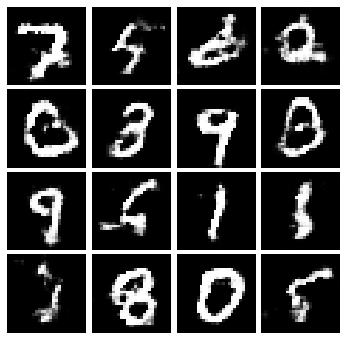

Labels :  (tensor([ 16.1157,   3.7748,   4.5456,   5.2639,   5.4928,   8.6782,
         11.9229,   5.8780,  10.4255,   7.8581,   7.6322,   5.8118,
          1.5887,   8.0380,  15.8292,   9.1600], device='cuda:0'), tensor([ 7,  5,  2,  2,  0,  3,  9,  3,  9,  5,  1,  1,  2,  8,
         0,  5], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=12, iteration=45001, WD=21.857860565185547, D_loss=-9.372720718383789, bce=0.3898322582244873, G_loss=-61.715797424316406
epoch=12, iteration=45101, WD=33.192081451416016, D_loss=-22.814285278320312, bce=0.29072093963623047, G_loss=-36.82478713989258
epoch=12, iteration=45201, WD=16.163158416748047, D_loss=-6.9627685546875, bce=0.1103982925415039, G_loss=-45.470420837402344
epoch=12, iteration=45301, WD=10.519317626953125, D_loss=0.5351076126098633, bce=0.38295650482177734, G_loss=-78.77647399902344
epoch=12, iteration=45401, WD=12.248054504394531, D_loss=-1.8642487525939941, bce=0.5559868812561035, G_loss=-100.87409973144531
epoch=12, itera

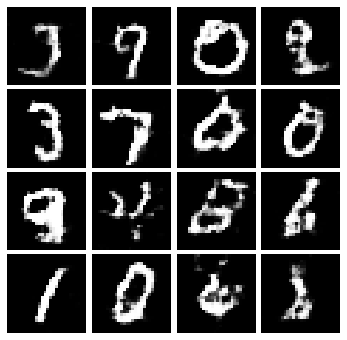

Labels :  (tensor([  6.2806,   6.0013,  11.9026,   5.0271,  10.2130,  17.5455,
          9.2398,  10.0379,   7.8457,   7.8112,   4.1283,   7.8450,
         10.5324,   9.8270,   9.6359,   4.2197], device='cuda:0'), tensor([ 7,  9,  0,  1,  3,  7,  0,  0,  3,  4,  6,  6,  1,  0,
         6,  1], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=13, iteration=48801, WD=25.623138427734375, D_loss=-13.511192321777344, bce=1.4651837348937988, G_loss=-79.91828918457031
epoch=13, iteration=48901, WD=4.562729835510254, D_loss=8.026262283325195, bce=3.161834478378296, G_loss=-2.570892095565796
epoch=13, iteration=49001, WD=14.8358154296875, D_loss=-4.529216289520264, bce=1.3235154151916504, G_loss=-106.94745635986328
epoch=13, iteration=49101, WD=18.74407196044922, D_loss=-10.52821159362793, bce=0.23606300354003906, G_loss=-95.05770111083984
epoch=13, iteration=49201, WD=48.17765808105469, D_loss=-36.91183853149414, bce=0.08607864379882812, G_loss=-32.15024948120117
epoch=13, iteration=493

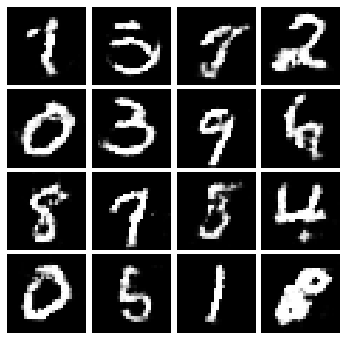

Labels :  (tensor([  5.9743,  10.9033,   2.7507,  17.8670,  13.8515,  15.8744,
         10.3398,   6.9097,   9.0235,  10.0294,   5.3638,  17.4033,
         12.3500,   3.2789,   8.6347,  11.6693], device='cuda:0'), tensor([ 1,  3,  7,  2,  0,  3,  9,  6,  8,  7,  5,  4,  0,  6,
         1,  8], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=14, iteration=52501, WD=26.872726440429688, D_loss=-17.121971130371094, bce=0.1103062629699707, G_loss=-85.52253723144531
epoch=14, iteration=52601, WD=24.706491470336914, D_loss=-15.748146057128906, bce=0.1410069465637207, G_loss=-17.066532135009766
epoch=14, iteration=52701, WD=51.84516143798828, D_loss=-39.91831970214844, bce=3.149420738220215, G_loss=-97.16158294677734
epoch=14, iteration=52801, WD=21.703773498535156, D_loss=-11.726035118103027, bce=0.09772109985351562, G_loss=-103.67489624023438
epoch=14, iteration=52901, WD=29.59084701538086, D_loss=-17.168201446533203, bce=3.213041305541992, G_loss=-32.54732894897461
epoch=14, iterati

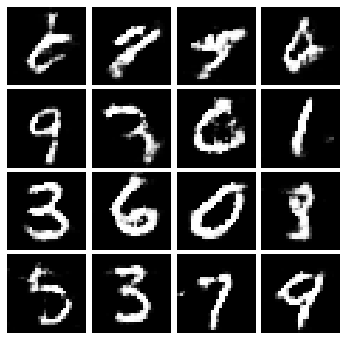

Labels :  (tensor([  4.0726,   5.2889,   2.9445,   5.3932,   9.5294,   9.1312,
          4.7015,   9.2897,  16.8432,  18.1763,  10.4542,   3.2876,
          9.2237,  14.3463,  10.1751,   8.2882], device='cuda:0'), tensor([ 8,  8,  4,  6,  9,  3,  6,  1,  3,  6,  0,  8,  5,  3,
         7,  9], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=15, iteration=56301, WD=31.08502197265625, D_loss=-23.622631072998047, bce=0.031249046325683594, G_loss=-48.92417907714844
epoch=15, iteration=56401, WD=20.536426544189453, D_loss=-12.011090278625488, bce=0.5186090469360352, G_loss=-30.4825382232666
epoch=15, iteration=56501, WD=18.52820587158203, D_loss=-9.159785270690918, bce=0.1820392608642578, G_loss=-29.497833251953125
epoch=15, iteration=56601, WD=28.748252868652344, D_loss=-15.254617691040039, bce=2.8601365089416504, G_loss=7.62822961807251
epoch=15, iteration=56701, WD=25.56298065185547, D_loss=-16.492874145507812, bce=1.188943862915039, G_loss=-64.99293518066406
epoch=15, iteration=

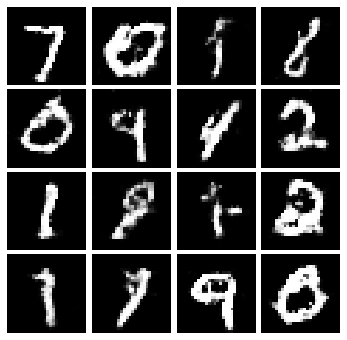

Labels :  (tensor([ 15.1330,  10.7692,   2.1045,   4.8129,   7.9267,   5.4680,
          6.1086,  10.5038,   8.1848,   4.8353,   0.9593,  11.8117,
          4.6483,   4.0388,  13.1960,  10.3493], device='cuda:0'), tensor([ 7,  0,  1,  8,  0,  9,  4,  2,  1,  8,  8,  2,  1,  7,
         9,  0], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=16, iteration=60001, WD=21.98839569091797, D_loss=-15.315911293029785, bce=0.18292713165283203, G_loss=-12.181417465209961
epoch=16, iteration=60101, WD=18.10057830810547, D_loss=-6.547879695892334, bce=0.7070193290710449, G_loss=-29.184669494628906
epoch=16, iteration=60201, WD=18.95006561279297, D_loss=-8.309176445007324, bce=1.739837646484375, G_loss=-72.27276611328125
epoch=16, iteration=60301, WD=30.809555053710938, D_loss=-15.740245819091797, bce=7.311365127563477, G_loss=-123.42902374267578
epoch=16, iteration=60401, WD=33.87792205810547, D_loss=-24.08955192565918, bce=2.159292459487915, G_loss=-93.91800689697266
epoch=16, iteration=6

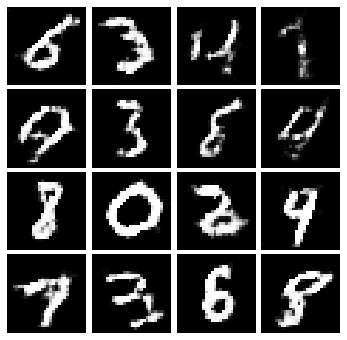

Labels :  (tensor([  6.6619,  11.1796,   8.2503,   1.1164,   5.8899,   9.1003,
          5.3020,   5.5959,   5.3021,  17.4679,  13.1622,   8.5634,
         12.9253,   9.7448,   7.4704,   6.8429], device='cuda:0'), tensor([ 6,  3,  4,  8,  9,  3,  8,  4,  8,  0,  2,  4,  7,  3,
         6,  8], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=17, iteration=63801, WD=19.803077697753906, D_loss=-9.405550003051758, bce=3.0238003730773926, G_loss=-70.44908142089844
epoch=17, iteration=63901, WD=23.294475555419922, D_loss=-13.097034454345703, bce=2.44034743309021, G_loss=-33.10063171386719
epoch=17, iteration=64001, WD=21.708127975463867, D_loss=-15.070474624633789, bce=0.06650781631469727, G_loss=-17.53207015991211
epoch=17, iteration=64101, WD=25.16278839111328, D_loss=-16.41908073425293, bce=0.1858386993408203, G_loss=-105.48894500732422
epoch=17, iteration=64201, WD=32.677574157714844, D_loss=-23.702239990234375, bce=0.8511228561401367, G_loss=-111.62088012695312
epoch=17, iterati

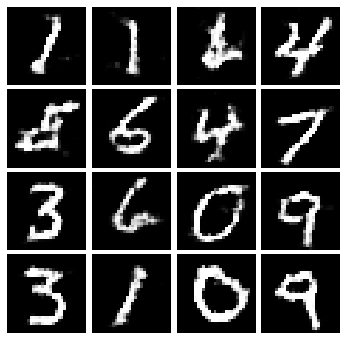

Labels :  (tensor([  5.9565,   5.1856,   3.2954,  14.4441,   8.8856,   9.0523,
          9.8217,  12.7947,  12.2639,  10.5463,   5.7032,  10.8840,
         13.7454,   4.4853,  16.3011,  12.3921], device='cuda:0'), tensor([ 1,  1,  6,  4,  5,  6,  4,  7,  3,  6,  0,  9,  3,  1,
         0,  9], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=18, iteration=67501, WD=2.0759401321411133, D_loss=7.038084983825684, bce=0.05393028259277344, G_loss=-13.347900390625
epoch=18, iteration=67601, WD=15.200506210327148, D_loss=-6.307053565979004, bce=0.41228652000427246, G_loss=-34.67690658569336
epoch=18, iteration=67701, WD=16.717567443847656, D_loss=-7.202195644378662, bce=1.490797519683838, G_loss=-23.353670120239258
epoch=18, iteration=67801, WD=5.5570526123046875, D_loss=3.7960448265075684, bce=2.301510810852051, G_loss=-59.656219482421875
epoch=18, iteration=67901, WD=18.564437866210938, D_loss=-8.945796012878418, bce=2.168499708175659, G_loss=-109.60670471191406
epoch=18, iteration=6

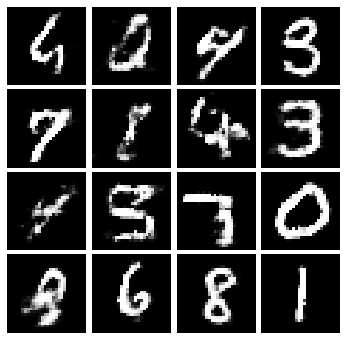

Labels :  (tensor([  3.7299,   1.9156,   9.1991,   8.4350,  11.6645,   3.7039,
          3.4931,  12.8267,   1.0788,  10.7055,  18.0424,  14.8624,
          6.1251,  11.0327,  12.0639,   7.1166], device='cuda:0'), tensor([ 6,  2,  4,  3,  7,  8,  6,  3,  4,  3,  7,  0,  8,  6,
         8,  1], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=19, iteration=71301, WD=9.274837493896484, D_loss=-1.600090742111206, bce=0.61763596534729, G_loss=-33.614105224609375
epoch=19, iteration=71401, WD=24.737060546875, D_loss=-16.843624114990234, bce=0.19865131378173828, G_loss=-4.677886962890625
epoch=19, iteration=71501, WD=29.470256805419922, D_loss=-22.61065673828125, bce=0.05218839645385742, G_loss=-67.94548797607422
epoch=19, iteration=71601, WD=12.537521362304688, D_loss=-4.875533580780029, bce=0.09849929809570312, G_loss=-54.70664978027344
epoch=19, iteration=71701, WD=5.812751770019531, D_loss=1.5696830749511719, bce=0.9531197547912598, G_loss=-81.21238708496094
epoch=19, iteration=71

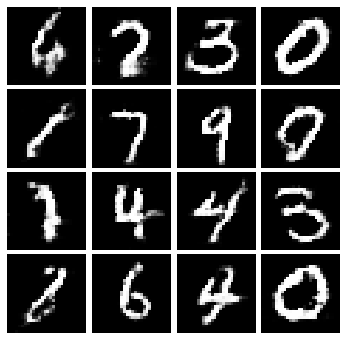

Labels :  (tensor([  7.6098,   9.6378,  14.1685,  16.1308,   4.9380,  12.9192,
          8.5254,   4.7557,   6.5352,  10.1571,  12.4128,  11.4315,
          3.2362,   9.4277,  11.5335,  12.7904], device='cuda:0'), tensor([ 6,  2,  3,  0,  1,  7,  9,  0,  1,  4,  4,  3,  8,  6,
         4,  0], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=20, iteration=75001, WD=32.30078887939453, D_loss=-24.710657119750977, bce=0.06693458557128906, G_loss=-114.03839111328125
epoch=20, iteration=75101, WD=34.89479064941406, D_loss=-28.33739471435547, bce=0.011650562286376953, G_loss=-117.07117462158203
epoch=20, iteration=75201, WD=29.313568115234375, D_loss=-20.65165138244629, bce=0.025915145874023438, G_loss=-169.01943969726562
epoch=20, iteration=75301, WD=34.226104736328125, D_loss=-19.76685905456543, bce=6.436044692993164, G_loss=-156.3692626953125
epoch=20, iteration=75401, WD=27.342041015625, D_loss=-19.836143493652344, bce=0.8890426158905029, G_loss=-133.52108764648438
epoch=20, itera

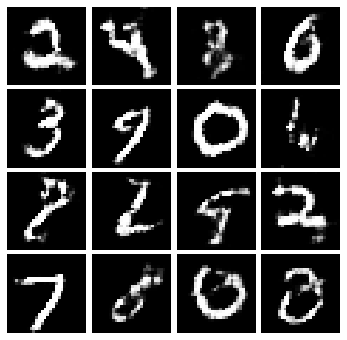

Labels :  (tensor([  8.7256,   3.5030,   2.8427,   8.3133,   9.1733,   5.0133,
         19.1865,   2.6087,   7.6450,  10.6623,   6.6775,   6.2227,
         15.4519,   1.9781,  14.2777,   3.9270], device='cuda:0'), tensor([ 2,  4,  8,  0,  3,  7,  0,  4,  8,  2,  5,  2,  7,  8,
         0,  0], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=21, iteration=78801, WD=23.59418487548828, D_loss=-17.57620620727539, bce=0.23513507843017578, G_loss=-106.66266632080078
epoch=21, iteration=78901, WD=13.008308410644531, D_loss=-5.655677318572998, bce=0.13319015502929688, G_loss=-104.33100891113281
epoch=21, iteration=79001, WD=30.58141326904297, D_loss=-22.6788387298584, bce=0.8970656394958496, G_loss=-110.79951477050781
epoch=21, iteration=79101, WD=34.24164581298828, D_loss=-21.87437629699707, bce=5.855405330657959, G_loss=-131.93443298339844
epoch=21, iteration=79201, WD=20.998077392578125, D_loss=-13.283979415893555, bce=0.26429033279418945, G_loss=-149.1082305908203
epoch=21, iterati

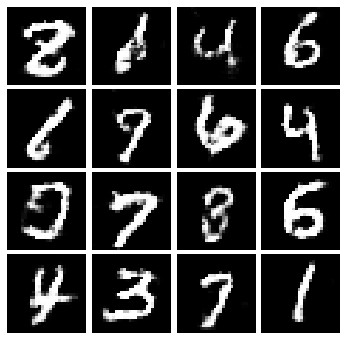

Labels :  (tensor([  9.6036,   4.1483,   7.8515,  11.5762,   7.9188,   5.7342,
         14.4764,   9.6018,   3.7641,  13.1126,   5.9231,   9.8956,
         12.6111,  12.6882,   8.9211,  11.1906], device='cuda:0'), tensor([ 8,  1,  4,  6,  1,  9,  6,  4,  0,  7,  8,  6,  4,  3,
         7,  1], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=22, iteration=82501, WD=40.36971664428711, D_loss=-33.37439727783203, bce=0.24767160415649414, G_loss=-56.03665542602539
epoch=22, iteration=82601, WD=7.8266143798828125, D_loss=0.16643714904785156, bce=0.2653069496154785, G_loss=-76.9042739868164
epoch=22, iteration=82701, WD=18.26276397705078, D_loss=-6.872254848480225, bce=4.613815784454346, G_loss=-29.741357803344727
epoch=22, iteration=82801, WD=-3.9168834686279297, D_loss=20.411455154418945, bce=8.935497283935547, G_loss=-13.203837394714355
epoch=22, iteration=82901, WD=14.375236511230469, D_loss=-4.605512619018555, bce=2.1864795684814453, G_loss=-29.121217727661133
epoch=22, iteration

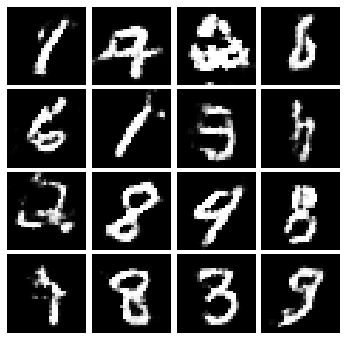

Labels :  (tensor([  6.8310,   2.6151,   8.5259,   4.9102,   6.0345,   9.1537,
          8.2250,   2.5919,   8.1737,  11.1155,   8.4899,   6.1004,
          2.6164,  10.4380,  12.0819,   5.2145], device='cuda:0'), tensor([ 1,  7,  2,  6,  6,  1,  3,  9,  2,  8,  9,  8,  9,  8,
         3,  3], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=23, iteration=86301, WD=14.938064575195312, D_loss=-8.4384183883667, bce=0.10829544067382812, G_loss=-102.4993667602539
epoch=23, iteration=86401, WD=30.86646270751953, D_loss=-21.660837173461914, bce=0.05479168891906738, G_loss=-83.38224792480469
epoch=23, iteration=86501, WD=8.550727844238281, D_loss=-1.188622236251831, bce=1.493976354598999, G_loss=-121.39452362060547
epoch=23, iteration=86601, WD=21.830062866210938, D_loss=-12.17652702331543, bce=1.4763293266296387, G_loss=-109.19983673095703
epoch=23, iteration=86701, WD=7.071510314941406, D_loss=0.3121539354324341, bce=0.2158886194229126, G_loss=-50.83257293701172
epoch=23, iteration=8

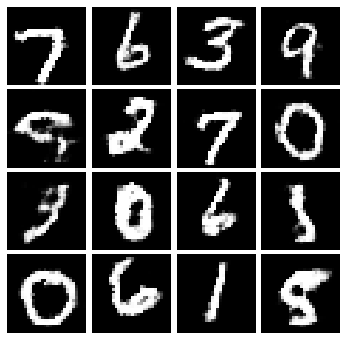

Labels :  (tensor([ 14.6637,  12.1042,  14.7419,   7.2126,   1.5949,   7.4803,
          9.4983,   8.3437,   3.1932,   9.0675,  11.9678,   9.5398,
         11.1402,  19.7693,   9.1789,   3.0553], device='cuda:0'), tensor([ 7,  6,  3,  9,  9,  2,  7,  0,  3,  0,  6,  1,  0,  6,
         1,  5], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=24, iteration=90001, WD=11.268689155578613, D_loss=-4.45529317855835, bce=0.07203245162963867, G_loss=42.69102478027344
epoch=24, iteration=90101, WD=3.99627685546875, D_loss=1.8587441444396973, bce=0.43272924423217773, G_loss=-55.7484245300293
epoch=24, iteration=90201, WD=22.459861755371094, D_loss=-14.504440307617188, bce=0.3748571276664734, G_loss=-101.8238754272461
epoch=24, iteration=90301, WD=14.508628845214844, D_loss=-8.093900680541992, bce=0.14615774154663086, G_loss=-88.61189270019531
epoch=24, iteration=90401, WD=15.757484436035156, D_loss=-8.761076927185059, bce=0.07306194305419922, G_loss=-87.49566650390625
epoch=24, iteration=

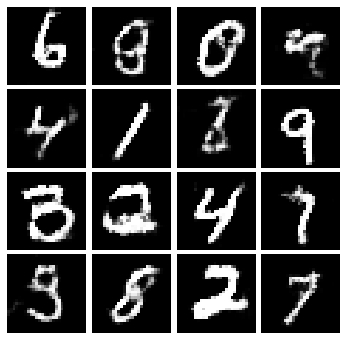

Labels :  (tensor([ 14.0752,   2.2939,   9.9286,   2.4090,   9.0397,   8.1345,
          1.9967,  11.7528,  10.1225,  12.4252,  11.8608,   6.3628,
          4.5349,   6.1207,  19.2686,   6.6938], device='cuda:0'), tensor([ 6,  8,  0,  9,  4,  1,  3,  9,  3,  2,  4,  7,  3,  8,
         2,  7], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=25, iteration=93801, WD=21.49627685546875, D_loss=-13.666292190551758, bce=0.5577297210693359, G_loss=-14.485040664672852
epoch=25, iteration=93901, WD=24.587562561035156, D_loss=-15.787126541137695, bce=0.032933712005615234, G_loss=-109.94818115234375
epoch=25, iteration=94001, WD=1.811370849609375, D_loss=5.170388221740723, bce=0.2473304271697998, G_loss=-79.38539123535156
epoch=25, iteration=94101, WD=12.881965637207031, D_loss=-6.8543267250061035, bce=0.008828163146972656, G_loss=-76.74832916259766
epoch=25, iteration=94201, WD=15.70327377319336, D_loss=-7.75616455078125, bce=0.37070584297180176, G_loss=-53.35284423828125
epoch=25, itera

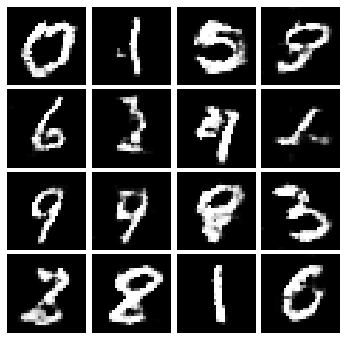

Labels :  (tensor([ 13.5107,   5.6992,   3.6186,   4.5928,  10.7768,   5.7674,
          0.8460,  -0.4514,   6.1337,   4.1047,  10.0668,   8.1009,
          4.6573,  14.7040,   8.5511,   2.6196], device='cuda:0'), tensor([ 0,  1,  5,  8,  6,  2,  9,  2,  9,  9,  8,  3,  3,  8,
         1,  6], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=26, iteration=97501, WD=19.716842651367188, D_loss=-13.06680965423584, bce=0.2848942279815674, G_loss=-101.77136993408203
epoch=26, iteration=97601, WD=20.73737335205078, D_loss=-12.553494453430176, bce=1.1236292123794556, G_loss=-116.45298767089844
epoch=26, iteration=97701, WD=33.97581481933594, D_loss=-25.232662200927734, bce=2.485178232192993, G_loss=-128.8824920654297
epoch=26, iteration=97801, WD=21.792789459228516, D_loss=-14.13936996459961, bce=1.058619737625122, G_loss=-67.22761535644531
epoch=26, iteration=97901, WD=5.5713653564453125, D_loss=0.9707174301147461, bce=0.07251167297363281, G_loss=-59.282196044921875
epoch=26, iteratio

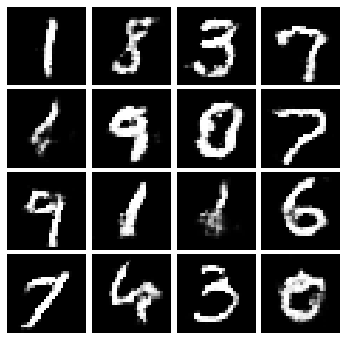

Labels :  (tensor([  7.2320,   2.8712,  12.3259,   8.4911,  -1.2128,   9.6269,
          7.1138,  13.1059,   8.9513,   7.1420,   0.7780,   8.3674,
          8.7605,   4.6877,  11.2527,   2.7582], device='cuda:0'), tensor([ 1,  8,  3,  7,  1,  9,  0,  7,  9,  1,  1,  6,  7,  4,
         3,  0], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=27, iteration=101301, WD=7.433832168579102, D_loss=-0.8981480598449707, bce=0.07617616653442383, G_loss=-14.422120094299316
epoch=27, iteration=101401, WD=6.434783935546875, D_loss=0.06356143951416016, bce=1.2268433570861816, G_loss=-56.65097427368164
epoch=27, iteration=101501, WD=22.72673797607422, D_loss=-16.112958908081055, bce=0.028430461883544922, G_loss=-69.78289794921875
epoch=27, iteration=101601, WD=-6.411754608154297, D_loss=12.480140686035156, bce=0.14339375495910645, G_loss=-59.3917350769043
epoch=27, iteration=101701, WD=15.83404541015625, D_loss=-9.662344932556152, bce=0.23173213005065918, G_loss=-48.096378326416016
epoch=27, 

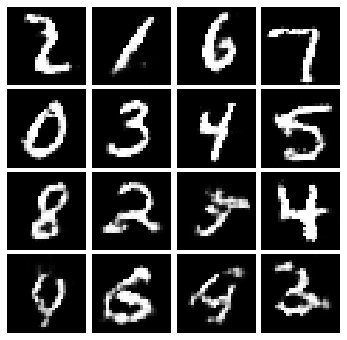

Labels :  (tensor([ 16.0084,   9.8971,  11.9876,  12.5049,  12.8443,  13.0172,
         11.9615,  13.8103,   8.3805,  11.5751,   1.2089,  14.5734,
          1.1966,   7.0616,   2.5717,   5.9755], device='cuda:0'), tensor([ 2,  1,  6,  7,  0,  3,  4,  5,  8,  2,  5,  4,  4,  5,
         4,  3], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=28, iteration=105001, WD=28.721908569335938, D_loss=-22.917142868041992, bce=0.06557309627532959, G_loss=-36.21751403808594
epoch=28, iteration=105101, WD=10.417213439941406, D_loss=-3.8786773681640625, bce=0.1099696159362793, G_loss=11.511103630065918
epoch=28, iteration=105201, WD=32.48377990722656, D_loss=-24.66611671447754, bce=0.2669816017150879, G_loss=37.36257553100586
epoch=28, iteration=105301, WD=15.752311706542969, D_loss=-7.830326080322266, bce=0.008907079696655273, G_loss=28.68366813659668
epoch=28, iteration=105401, WD=20.394180297851562, D_loss=-11.584549903869629, bce=0.307415246963501, G_loss=-16.367965698242188
epoch=28, it

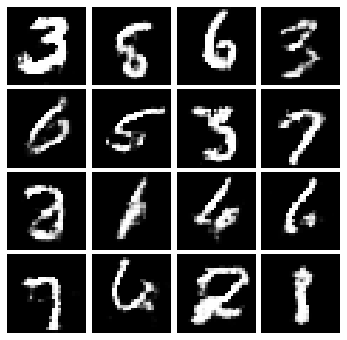

Labels :  (tensor([ 11.0676,  10.7889,  14.5124,   9.0943,   0.3024,  12.2083,
          8.5054,   7.3620,   8.0956,   4.2295,   3.6102,   4.8709,
         10.2461,   3.3620,  10.7368,   4.9528], device='cuda:0'), tensor([ 3,  5,  6,  3,  6,  5,  3,  7,  3,  1,  6,  6,  7,  6,
         2,  1], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=29, iteration=108801, WD=19.235347747802734, D_loss=-13.884310722351074, bce=0.02319622039794922, G_loss=-61.847713470458984
epoch=29, iteration=108901, WD=13.529529571533203, D_loss=-8.106531143188477, bce=0.008051872253417969, G_loss=-30.838624954223633
epoch=29, iteration=109001, WD=28.62944221496582, D_loss=-20.28227996826172, bce=2.874373197555542, G_loss=-27.50741195678711
epoch=29, iteration=109101, WD=3.6996307373046875, D_loss=1.5985355377197266, bce=0.0548405647277832, G_loss=-67.58304595947266
epoch=29, iteration=109201, WD=3.297454833984375, D_loss=2.6537671089172363, bce=0.24741306900978088, G_loss=-110.22565460205078
epoch=29, 

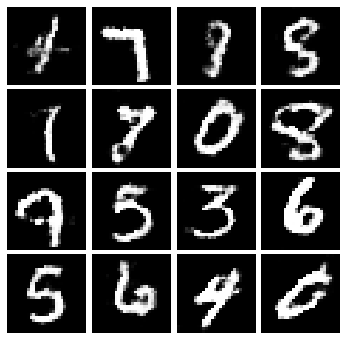

Labels :  (tensor([ -0.6138,  13.6714,   3.0605,   4.1732,   5.8700,   9.6538,
          7.8645,   6.8335,   7.7165,   7.7792,   9.6461,  16.8387,
          8.1762,  12.7921,   6.4572,   3.2441], device='cuda:0'), tensor([ 1,  7,  7,  8,  1,  7,  0,  8,  9,  5,  3,  6,  5,  6,
         4,  0], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=30, iteration=112501, WD=31.81494140625, D_loss=-25.11626625061035, bce=0.1349421739578247, G_loss=-102.24388122558594
epoch=30, iteration=112601, WD=7.748970031738281, D_loss=1.5761253833770752, bce=2.163370370864868, G_loss=-132.74696350097656
epoch=30, iteration=112701, WD=17.78106689453125, D_loss=-11.700505256652832, bce=0.1644921898841858, G_loss=-108.580810546875
epoch=30, iteration=112801, WD=2.567535400390625, D_loss=3.5078439712524414, bce=0.05819705128669739, G_loss=-96.01276397705078
epoch=30, iteration=112901, WD=17.316238403320312, D_loss=-12.249760627746582, bce=0.004604339599609375, G_loss=-35.79454040527344
epoch=30, iterati

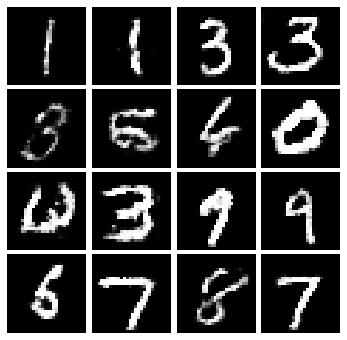

Labels :  (tensor([  4.0691,   5.8291,   9.7983,  10.8533,   3.0262,   1.3620,
          2.2554,   9.0727,   5.5434,  14.1060,   4.9728,   5.4048,
          5.8602,  15.0341,   5.7143,  12.2703], device='cuda:0'), tensor([ 1,  1,  3,  3,  3,  5,  6,  0,  4,  3,  9,  9,  6,  7,
         8,  7], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=31, iteration=116301, WD=13.627967834472656, D_loss=-8.38136100769043, bce=0.08811569213867188, G_loss=-63.44706726074219
epoch=31, iteration=116401, WD=12.027046203613281, D_loss=-6.690056800842285, bce=0.07436227798461914, G_loss=-120.27261352539062
epoch=31, iteration=116501, WD=-2.48565673828125, D_loss=7.932492733001709, bce=0.4246082305908203, G_loss=-61.59340286254883
epoch=31, iteration=116601, WD=17.979219436645508, D_loss=-12.293472290039062, bce=0.17004919052124023, G_loss=-31.2358455657959
epoch=31, iteration=116701, WD=18.77724266052246, D_loss=-13.224255561828613, bce=0.49048304557800293, G_loss=-1.6236917972564697
epoch=31, it

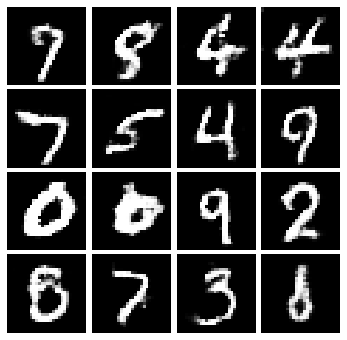

Labels :  (tensor([  7.0705,   0.4597,   4.7298,  11.9480,  11.8857,  11.1009,
          9.3574,   7.1061,  13.6036,   4.9067,   9.5507,   9.1203,
          0.8565,  10.9886,  10.2429,   0.8338], device='cuda:0'), tensor([ 7,  8,  4,  4,  7,  5,  4,  9,  0,  0,  9,  2,  0,  7,
         3,  8], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=32, iteration=120001, WD=6.779167175292969, D_loss=-1.4927608966827393, bce=0.2903030514717102, G_loss=-58.53218460083008
epoch=32, iteration=120101, WD=16.426925659179688, D_loss=-10.150102615356445, bce=0.2941265106201172, G_loss=-63.66683578491211
epoch=32, iteration=120201, WD=8.213478088378906, D_loss=-2.696089267730713, bce=0.17457151412963867, G_loss=-94.63345336914062
epoch=32, iteration=120301, WD=23.02520751953125, D_loss=-15.081918716430664, bce=2.2719173431396484, G_loss=-74.91287231445312
epoch=32, iteration=120401, WD=15.515331268310547, D_loss=-9.408039093017578, bce=0.2626621723175049, G_loss=-60.96501922607422
epoch=32, iter

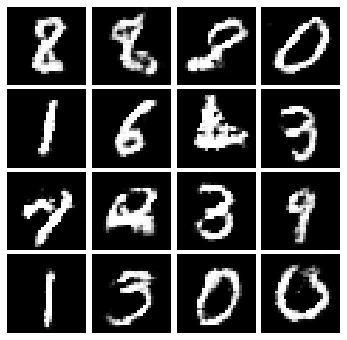

Labels :  (tensor([  6.8280,   5.3361,   7.4738,  11.8980,   8.2043,   9.7358,
          9.1155,   7.8724,   3.3874,   3.8226,   8.8911,   4.5582,
          6.9659,   9.0727,   9.9730,   8.2929], device='cuda:0'), tensor([ 8,  8,  8,  0,  1,  6,  6,  3,  7,  4,  3,  9,  1,  3,
         0,  0], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=33, iteration=123801, WD=3.35284423828125, D_loss=1.2114801406860352, bce=0.0875558853149414, G_loss=-25.756698608398438
epoch=33, iteration=123901, WD=16.709896087646484, D_loss=-10.812108993530273, bce=0.34891852736473083, G_loss=31.792137145996094
epoch=33, iteration=124001, WD=12.138561248779297, D_loss=-5.231603622436523, bce=0.4061223268508911, G_loss=14.036881446838379
epoch=33, iteration=124101, WD=18.209884643554688, D_loss=-11.284976959228516, bce=2.0953688621520996, G_loss=-66.14183044433594
epoch=33, iteration=124201, WD=17.6513671875, D_loss=-12.383649826049805, bce=0.0857236385345459, G_loss=-102.65196990966797
epoch=33, iterat

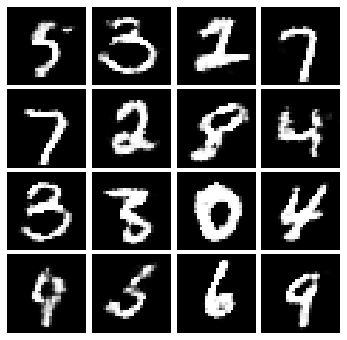

Labels :  (tensor([  4.1775,   6.3064,  13.0623,  12.0932,  12.2132,  12.5037,
          4.5701,   8.9343,   3.8031,  10.6532,  13.8308,   9.8003,
          0.0078,   2.5689,  17.0455,   4.5284], device='cuda:0'), tensor([ 5,  3,  2,  7,  7,  2,  8,  4,  3,  3,  0,  4,  4,  5,
         6,  9], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=34, iteration=127501, WD=18.011878967285156, D_loss=-12.96126651763916, bce=0.13831806182861328, G_loss=-24.0211124420166
epoch=34, iteration=127601, WD=13.856239318847656, D_loss=-7.921046257019043, bce=0.012071371078491211, G_loss=-31.14116668701172
epoch=34, iteration=127701, WD=20.759052276611328, D_loss=-14.803153991699219, bce=0.5721240043640137, G_loss=-60.10942459106445
epoch=34, iteration=127801, WD=2.937633514404297, D_loss=2.1412839889526367, bce=0.050469398498535156, G_loss=-54.77497863769531
epoch=34, iteration=127901, WD=3.082611083984375, D_loss=1.5898170471191406, bce=0.102630615234375, G_loss=-63.09319305419922
epoch=34, ite

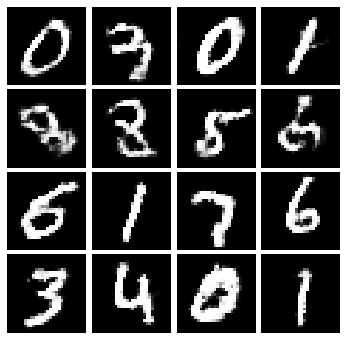

Labels :  (tensor([ 11.0947,   5.5668,  13.7722,   6.6837,  -2.2729,   6.9778,
          8.6041,   1.3387,   4.7814,   7.3614,  10.1952,  10.0874,
         15.1114,   6.2613,   8.2521,   3.8429], device='cuda:0'), tensor([ 0,  3,  0,  1,  3,  3,  5,  6,  5,  1,  7,  6,  3,  4,
         0,  1], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=35, iteration=131301, WD=14.266319274902344, D_loss=-7.469146728515625, bce=1.8018380403518677, G_loss=-72.14292907714844
epoch=35, iteration=131401, WD=8.642807006835938, D_loss=-4.560295104980469, bce=0.017474651336669922, G_loss=-44.25372314453125
epoch=35, iteration=131501, WD=8.494619369506836, D_loss=-1.7671408653259277, bce=0.0008301734924316406, G_loss=20.456941604614258
epoch=35, iteration=131601, WD=15.312671661376953, D_loss=-10.752881050109863, bce=0.06106913089752197, G_loss=-0.29882311820983887
epoch=35, iteration=131701, WD=9.174301147460938, D_loss=-4.126100540161133, bce=0.05879378318786621, G_loss=-90.30598449707031
epoch=3

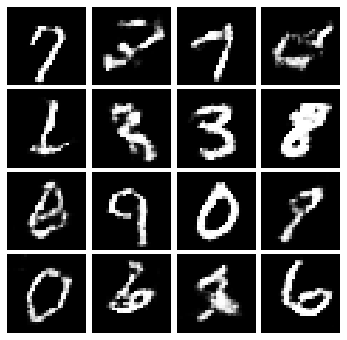

Labels :  (tensor([  6.0522,   4.1646,   6.6671,   0.4546,   6.5328,  -0.0750,
         12.2718,   7.1702,   0.0773,   7.7698,  14.4719,   0.2548,
          7.0784,   7.3313,   3.4421,  14.0645], device='cuda:0'), tensor([ 7,  8,  7,  4,  1,  3,  3,  8,  0,  9,  0,  8,  0,  6,
         2,  6], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=36, iteration=135001, WD=13.855453491210938, D_loss=-8.409524917602539, bce=0.07517600059509277, G_loss=-74.87794494628906
epoch=36, iteration=135101, WD=-2.6902084350585938, D_loss=8.376350402832031, bce=0.3013498783111572, G_loss=-42.201255798339844
epoch=36, iteration=135201, WD=6.080031394958496, D_loss=-0.4220459461212158, bce=0.09807133674621582, G_loss=19.00533103942871
epoch=36, iteration=135301, WD=6.9232940673828125, D_loss=-1.7238702774047852, bce=0.2749900817871094, G_loss=-57.5235710144043
epoch=36, iteration=135401, WD=0.47625732421875, D_loss=6.332920074462891, bce=0.9997575283050537, G_loss=-51.9682502746582
epoch=36, iterati

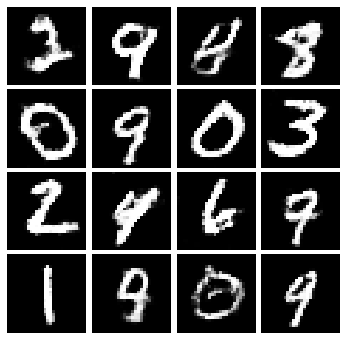

Labels :  (tensor([  1.9857,   7.3653,   6.1835,   6.0209,   7.8217,   8.3096,
          9.8951,  20.9303,  12.3245,   5.6243,  12.5557,   2.5948,
          5.0265,   1.1837,   0.3659,   5.9118], device='cuda:0'), tensor([ 3,  9,  4,  8,  0,  9,  0,  3,  2,  4,  6,  9,  1,  9,
         9,  9], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=37, iteration=138801, WD=13.435787200927734, D_loss=-9.148332595825195, bce=0.00089263916015625, G_loss=-57.17897415161133
epoch=37, iteration=138901, WD=5.965600967407227, D_loss=-1.4483623504638672, bce=0.02512359619140625, G_loss=-15.155921936035156
epoch=37, iteration=139001, WD=8.3369140625, D_loss=-2.997849464416504, bce=0.04100751876831055, G_loss=-22.819210052490234
epoch=37, iteration=139101, WD=5.872570037841797, D_loss=-0.04807502031326294, bce=0.6292998194694519, G_loss=-22.44707679748535
epoch=37, iteration=139201, WD=-0.0707244873046875, D_loss=5.757604122161865, bce=0.06121015548706055, G_loss=-95.22189331054688
epoch=37, iter

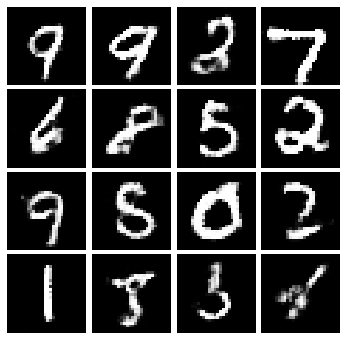

Labels :  (tensor([  5.9784,   8.3298,   5.6093,  20.5489,   3.3235,   6.3681,
          7.0552,   9.6579,   7.2246,   4.0114,   9.0586,   5.2060,
          7.1349,   3.2756,   1.0314,  -2.3703], device='cuda:0'), tensor([ 9,  9,  2,  7,  6,  8,  5,  2,  9,  5,  0,  2,  1,  3,
         3,  4], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=38, iteration=142501, WD=-2.138904333114624, D_loss=8.407114028930664, bce=0.8696718215942383, G_loss=-0.626715898513794
epoch=38, iteration=142601, WD=11.308504104614258, D_loss=-6.272693157196045, bce=0.0021386146545410156, G_loss=-33.634613037109375
epoch=38, iteration=142701, WD=9.113302230834961, D_loss=-4.337881088256836, bce=0.020575523376464844, G_loss=-9.849786758422852
epoch=38, iteration=142801, WD=4.558753967285156, D_loss=0.6303920745849609, bce=0.6153888702392578, G_loss=-90.02334594726562
epoch=38, iteration=142901, WD=12.009025573730469, D_loss=-6.849149227142334, bce=0.021227538585662842, G_loss=-101.026611328125
epoch=38, i

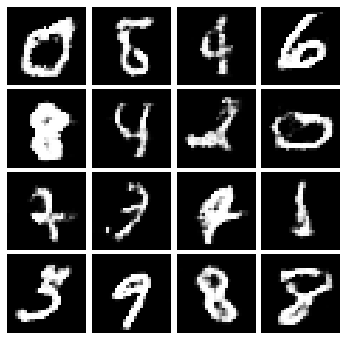

Labels :  (tensor([  6.6810,   5.9011,   1.7660,  15.0009,   9.3467,   5.1237,
          4.3624,   2.9767,  -0.4791,   1.7668,   2.2099,   2.6820,
          5.7979,   7.8995,   7.5122,   8.6448], device='cuda:0'), tensor([ 0,  5,  4,  6,  8,  4,  2,  0,  7,  3,  4,  1,  3,  9,
         8,  8], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=39, iteration=146301, WD=7.509346008300781, D_loss=-3.2992632389068604, bce=0.03976607322692871, G_loss=-75.07136535644531
epoch=39, iteration=146401, WD=23.534812927246094, D_loss=-17.96030044555664, bce=0.43007612228393555, G_loss=-72.2683334350586
epoch=39, iteration=146501, WD=9.514583587646484, D_loss=-4.580358982086182, bce=0.03709602355957031, G_loss=-44.61620330810547
epoch=39, iteration=146601, WD=7.573692321777344, D_loss=-3.1368942260742188, bce=0.0027213096618652344, G_loss=-17.783906936645508
epoch=39, iteration=146701, WD=1.449951171875, D_loss=3.542667865753174, bce=0.18223333358764648, G_loss=-19.755393981933594
epoch=39, ite

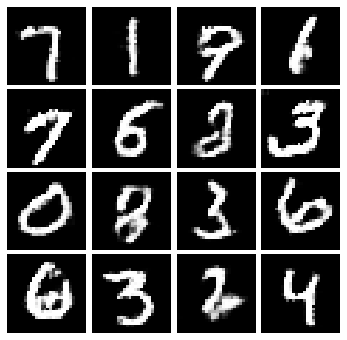

Labels :  (tensor([  9.6158,   5.2656,   3.2547,  -0.3505,   3.8892,   6.0940,
          3.8424,  11.4424,   5.4416,  -2.8936,   7.6776,  22.9915,
         14.4320,  18.5563,   5.3885,   8.7331], device='cuda:0'), tensor([ 7,  1,  9,  6,  7,  6,  2,  3,  0,  8,  3,  6,  6,  3,
         2,  4], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=40, iteration=150001, WD=14.456321716308594, D_loss=-9.0064115524292, bce=0.15241894125938416, G_loss=-16.695314407348633
epoch=40, iteration=150101, WD=12.91864013671875, D_loss=-6.53580379486084, bce=1.0794576406478882, G_loss=-99.29414367675781
epoch=40, iteration=150201, WD=1.1442718505859375, D_loss=5.559116363525391, bce=1.1021493673324585, G_loss=-110.4025650024414
epoch=40, iteration=150301, WD=4.531742095947266, D_loss=0.5722597241401672, bce=0.6070407032966614, G_loss=-44.01517105102539
epoch=40, iteration=150401, WD=7.377606391906738, D_loss=-1.0107276439666748, bce=0.7231218814849854, G_loss=-8.334783554077148
epoch=40, iteration

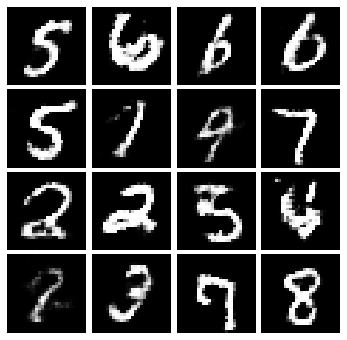

Labels :  (tensor([  7.8639,  23.3611,   4.2390,   6.2181,  14.5687,   3.2774,
          2.3259,  12.0293,  11.5758,  14.8765,   3.3471,   8.1495,
          0.1067,   6.5770,   3.5162,   8.6130], device='cuda:0'), tensor([ 5,  6,  6,  6,  5,  1,  9,  7,  2,  2,  5,  4,  8,  3,
         9,  8], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=41, iteration=153801, WD=4.93023681640625, D_loss=3.506105422973633, bce=3.200000762939453, G_loss=4.756274223327637
epoch=41, iteration=153901, WD=8.798145294189453, D_loss=-3.5292863845825195, bce=0.06983089447021484, G_loss=-19.815380096435547
epoch=41, iteration=154001, WD=21.43692398071289, D_loss=-16.902637481689453, bce=0.06202530860900879, G_loss=-26.899105072021484
epoch=41, iteration=154101, WD=19.90483283996582, D_loss=-15.660158157348633, bce=0.0011677742004394531, G_loss=-32.581146240234375
epoch=41, iteration=154201, WD=3.310352325439453, D_loss=6.709643840789795, bce=4.967941761016846, G_loss=-41.61978530883789
epoch=41, itera

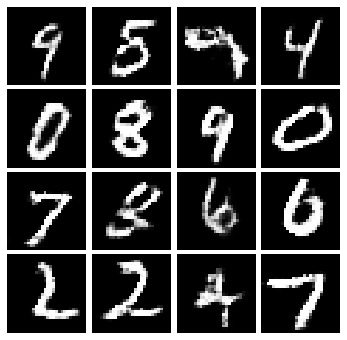

Labels :  (tensor([  4.0257,   9.2294,  -0.9799,   9.4821,   6.5424,   4.1629,
          5.2409,   9.4559,   5.8375,   0.2550,   6.8078,   5.5749,
         13.6160,  18.4910,   1.8668,  14.9323], device='cuda:0'), tensor([ 9,  5,  4,  4,  0,  8,  9,  0,  7,  3,  6,  0,  2,  2,
         4,  7], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=42, iteration=157501, WD=20.506301879882812, D_loss=-14.350768089294434, bce=0.7297905087471008, G_loss=-97.39063262939453
epoch=42, iteration=157601, WD=10.595096588134766, D_loss=-6.237916469573975, bce=0.046911656856536865, G_loss=-21.220312118530273
epoch=42, iteration=157701, WD=20.0494384765625, D_loss=-15.572006225585938, bce=0.0353541374206543, G_loss=1.7514721155166626
epoch=42, iteration=157801, WD=6.927431106567383, D_loss=-1.304903268814087, bce=0.008605718612670898, G_loss=-29.165966033935547
epoch=42, iteration=157901, WD=7.748023986816406, D_loss=-1.962770938873291, bce=1.178579330444336, G_loss=-41.25273132324219
epoch=42, it

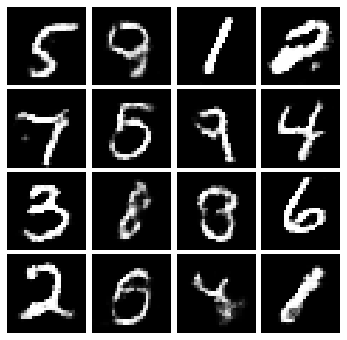

Labels :  (tensor([ 14.8059,   3.0141,   8.4006,  12.9938,   9.2615,   5.8868,
          0.3680,   8.9907,   8.7500,   1.1222,  -0.0816,  11.6269,
         12.8125,   4.1470,   0.5697,   6.6151], device='cuda:0'), tensor([ 5,  9,  1,  2,  7,  5,  3,  4,  3,  8,  0,  6,  2,  5,
         4,  1], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=43, iteration=161301, WD=10.059860229492188, D_loss=-4.991868019104004, bce=0.0027565956115722656, G_loss=-135.83517456054688
epoch=43, iteration=161401, WD=15.773399353027344, D_loss=-10.834983825683594, bce=0.029851794242858887, G_loss=-98.512939453125
epoch=43, iteration=161501, WD=8.853805541992188, D_loss=-4.854386329650879, bce=0.0010156631469726562, G_loss=-46.56251525878906
epoch=43, iteration=161601, WD=13.714851379394531, D_loss=-5.117727756500244, bce=3.4269518852233887, G_loss=-3.7544515132904053
epoch=43, iteration=161701, WD=7.732719421386719, D_loss=-2.4872472286224365, bce=0.003895998001098633, G_loss=-7.603033542633057
epoch

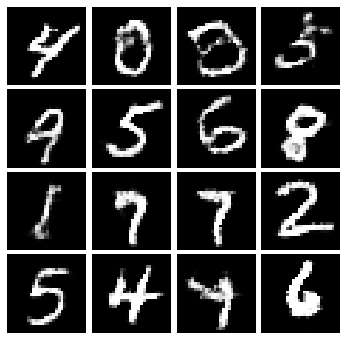

Labels :  (tensor([ 10.1867,   6.2872,  -0.9804,   2.3466,   7.7034,  15.8842,
          2.3541,   8.4625,   2.9538,   6.8918,   8.6185,   8.5993,
         12.0622,  13.1720,   1.7794,  12.1568], device='cuda:0'), tensor([ 4,  0,  3,  5,  9,  5,  6,  8,  1,  7,  7,  2,  5,  4,
         4,  6], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=44, iteration=165001, WD=4.991774559020996, D_loss=0.24619078636169434, bce=0.6028025150299072, G_loss=-16.286531448364258
epoch=44, iteration=165101, WD=11.18292236328125, D_loss=-5.787091255187988, bce=0.22374343872070312, G_loss=26.299907684326172
epoch=44, iteration=165201, WD=-2.376744270324707, D_loss=13.620162963867188, bce=6.653083324432373, G_loss=-18.00882911682129
epoch=44, iteration=165301, WD=2.325916290283203, D_loss=3.078993082046509, bce=0.01078343391418457, G_loss=-45.93906021118164
epoch=44, iteration=165401, WD=14.021682739257812, D_loss=-9.133766174316406, bce=0.0008282661437988281, G_loss=-77.77276611328125
epoch=44, ite

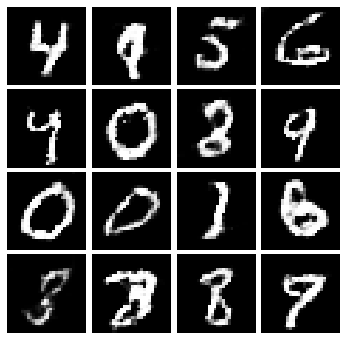

Labels :  (tensor([ 11.4963,   1.2826,   3.1457,   8.6624,   4.2187,  12.1875,
          2.1573,   2.5980,  14.7129,   7.5081,   5.2717,   9.3234,
          0.8161,   7.3535,   5.4368,   0.1180], device='cuda:0'), tensor([ 4,  9,  5,  6,  4,  0,  2,  4,  0,  0,  1,  6,  8,  3,
         8,  7], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=45, iteration=168801, WD=8.566909790039062, D_loss=-2.9567184448242188, bce=0.6970863342285156, G_loss=-83.55741882324219
epoch=45, iteration=168901, WD=18.73065948486328, D_loss=-13.559957504272461, bce=0.07559859752655029, G_loss=-57.61271286010742
epoch=45, iteration=169001, WD=14.22357177734375, D_loss=-8.619041442871094, bce=0.05294609069824219, G_loss=-101.6333236694336
epoch=45, iteration=169101, WD=8.745269775390625, D_loss=-4.120209693908691, bce=0.3381505012512207, G_loss=-53.15631866455078
epoch=45, iteration=169201, WD=7.370259761810303, D_loss=-2.047236919403076, bce=0.02697134017944336, G_loss=0.6212034225463867
epoch=45, itera

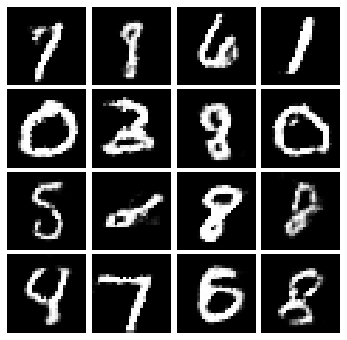

Labels :  (tensor([  5.4837,  -1.0651,   8.6430,   7.4296,  14.4262,   3.1099,
          3.7635,   8.0747,   3.6808,  -3.3909,  10.0265,   1.6605,
          4.5057,  12.2472,   4.2192,   0.5643], device='cuda:0'), tensor([ 7,  8,  6,  1,  0,  2,  8,  0,  5,  2,  8,  8,  4,  7,
         5,  8], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=46, iteration=172501, WD=2.4276123046875, D_loss=2.744847536087036, bce=0.0036309361457824707, G_loss=-73.06348419189453
epoch=46, iteration=172601, WD=0.609649658203125, D_loss=6.571951866149902, bce=2.6945600509643555, G_loss=-72.09906005859375
epoch=46, iteration=172701, WD=5.3780364990234375, D_loss=-1.095617413520813, bce=0.10122382640838623, G_loss=-58.02055358886719
epoch=46, iteration=172801, WD=15.474235534667969, D_loss=-9.776029586791992, bce=0.4740649461746216, G_loss=-47.106971740722656
epoch=46, iteration=172901, WD=12.515174865722656, D_loss=-8.295748710632324, bce=0.310824453830719, G_loss=-36.07621765136719
epoch=46, iterati

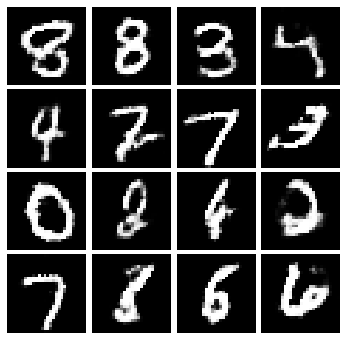

Labels :  (tensor([  2.6165,   2.8348,  11.5509,  -1.2757,   5.3945,   6.4652,
         10.1418,  -0.8603,  13.9985,   0.8032,   2.1230,   7.0289,
          6.8255,  -1.4288,   8.9315,  14.1570], device='cuda:0'), tensor([ 8,  8,  3,  4,  4,  2,  7,  3,  0,  2,  6,  2,  7,  8,
         6,  6], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=47, iteration=176301, WD=21.512985229492188, D_loss=-17.068574905395508, bce=0.016504526138305664, G_loss=-73.10994720458984
epoch=47, iteration=176401, WD=11.872766494750977, D_loss=-7.2298784255981445, bce=0.036563873291015625, G_loss=22.438255310058594
epoch=47, iteration=176501, WD=13.312782287597656, D_loss=-7.6071295738220215, bce=0.07734239101409912, G_loss=-40.419803619384766
epoch=47, iteration=176601, WD=5.902503967285156, D_loss=-1.388637661933899, bce=0.27761590480804443, G_loss=-47.86566162109375
epoch=47, iteration=176701, WD=11.542461395263672, D_loss=-7.383162498474121, bce=0.0019030570983886719, G_loss=-47.74565505981445
epo

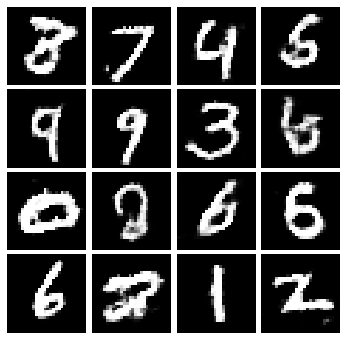

Labels :  (tensor([ -0.0756,   8.9611,   2.5284,   1.1592,   1.0663,   3.5810,
         11.0085,  10.8534,  14.8241,  -1.4543,   7.8696,   3.0291,
         11.7234,   3.4912,   6.4133,   8.7639], device='cuda:0'), tensor([ 8,  7,  9,  6,  9,  9,  3,  6,  0,  8,  6,  6,  6,  2,
         1,  2], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=48, iteration=180001, WD=23.96623992919922, D_loss=-17.97069549560547, bce=0.2330428510904312, G_loss=52.8631591796875
epoch=48, iteration=180101, WD=6.706939697265625, D_loss=-1.2364660501480103, bce=0.11865842342376709, G_loss=-123.31285095214844
epoch=48, iteration=180201, WD=19.17115020751953, D_loss=-14.339280128479004, bce=0.040383338928222656, G_loss=-63.7314338684082
epoch=48, iteration=180301, WD=16.683666229248047, D_loss=-11.601819038391113, bce=1.0454216003417969, G_loss=20.086538314819336
epoch=48, iteration=180401, WD=16.601219177246094, D_loss=-11.345941543579102, bce=0.33169713616371155, G_loss=4.576172828674316
epoch=48, ite

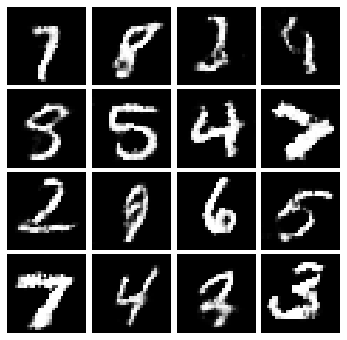

Labels :  (tensor([  7.3527,   1.9002,   0.9866,  -2.4845,   1.4828,   9.3834,
          7.5602,  -0.9604,   4.5103,   0.3008,  13.3287,   5.3131,
         10.2166,   6.6368,  -2.5247,   7.7451], device='cuda:0'), tensor([ 7,  8,  3,  7,  5,  5,  4,  2,  2,  9,  6,  5,  7,  4,
         7,  3], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=49, iteration=183801, WD=11.331180572509766, D_loss=-6.9624247550964355, bce=0.1372891664505005, G_loss=-36.922080993652344
epoch=49, iteration=183901, WD=5.9080810546875, D_loss=-1.708517074584961, bce=0.03588056564331055, G_loss=-85.14923858642578
epoch=49, iteration=184001, WD=26.55988311767578, D_loss=-21.84465217590332, bce=0.025177001953125, G_loss=-88.49874114990234
epoch=49, iteration=184101, WD=13.649374008178711, D_loss=-10.147780418395996, bce=0.0043288469314575195, G_loss=-27.939725875854492
epoch=49, iteration=184201, WD=1.5850639343261719, D_loss=3.0905022621154785, bce=0.0032123327255249023, G_loss=3.8742434978485107
epoch=49,

In [21]:
g = Generator().cuda()
d = Discriminator().cuda()
loss = train(g,d,l=1e-4,n_epochs=50, weight_decay=False)

In [0]:
loss = np.array(loss)

Text(0,0.5,'Wasserstein Distance')

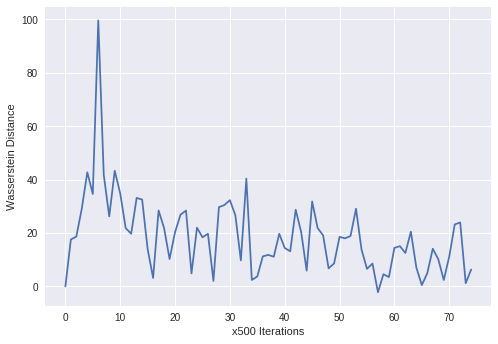

In [41]:
plt.plot(loss[::500,0])
plt.xlabel("x500 Iterations")
plt.ylabel("Wasserstein Distance")

Text(0,0.5,'Discriminator Loss')

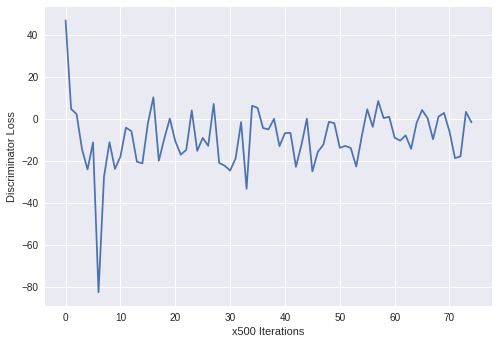

In [42]:
plt.plot(loss[::500,1])
plt.xlabel("x500 Iterations")
plt.ylabel("Discriminator Loss")

Text(0,0.5,'Crossentropy - No size average')

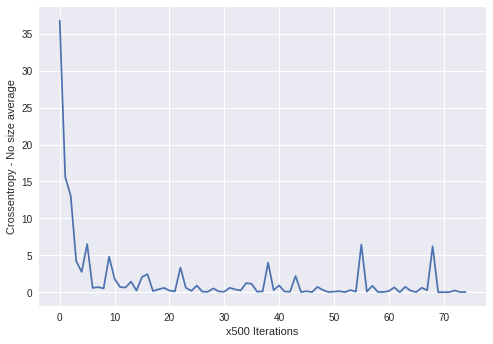

In [45]:
plt.plot(loss[::500,2])
plt.xlabel("x500 Iterations")
plt.ylabel("Crossentropy - No size average")

Text(0,0.5,'Generator Loss')

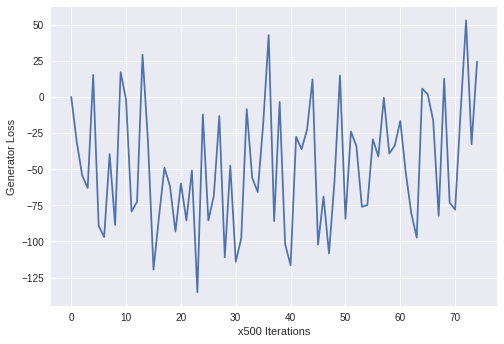

In [47]:
plt.plot(loss[::500,3])
plt.xlabel("x500 Iterations")
plt.ylabel("Generator Loss")